<a href="https://colab.research.google.com/github/MoonJaeHoon/Dacon_Behavioral_Data_Analysis/blob/master/%EB%B2%88%EC%99%B8_Camera_%EB%B3%80%EC%88%98_Plot_%EC%8B%9C%EA%B0%81%ED%99%94%ED%95%B4%EB%B3%B4%EA%B8%B0%26RMSW%EA%B5%AC%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
print( '변경 전 기본 경로 :' )
print(  os.getcwd() )
os.chdir('./drive/My Drive/데이콘_게임데이터분석')
print( '변경 후 파일 경로 :' )
print(  os.getcwd()  )

import numpy as np
import pandas as pd

from tqdm import tqdm_notebook              # 진행바
from sklearn.metrics import roc_auc_score   # AUC 스코어 계산
from sklearn.model_selection import KFold   # K-fold CV    
#from bayes_opt import BayesianOptimization  # 베이지안 최적화 라이브러리  
from functools import partial               # 함수 변수 고정
import lightgbm as lgb                      # LightGBM 라이브러리
import warnings                             
warnings.filterwarnings("ignore")           # 경고 문구 미표시
%time
train = pd.read_csv('./train.csv')

#%time
#test = pd.read_pickle('./test.pkl')

변경 전 기본 경로 :
/content
변경 후 파일 경로 :
/content/drive/My Drive/데이콘_게임데이터분석
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


## 함수명: plot_camera
### Args: DataFrame, game_id

* 데이터 프레임 (train, test)와 game_id를 입력하면 카메라에 해당하는 위치를 표시해 줍니다.
* 추가로 해당 게임의 전체 게임시간,  승자, 플레이어의 종족을 표기합니다.


In [0]:
import matplotlib.pyplot as plt
def plot_camera(dataframe, game_id):
    distance_list = []
    dataframe = dataframe.loc[dataframe['game_id']==game_id]
    dataframe = dataframe.loc[dataframe['event']=='Camera']
    dataframe_0 = dataframe.loc[dataframe['player']==0]
    dataframe_1 = dataframe.loc[dataframe['player']==1]

    winner = dataframe['winner'].iloc[0]
    game_time = dataframe['time'].values[-1]

    if dataframe_0.shape[0]!=0:
      player_0_species = dataframe_0['species'].iloc[0]
      player0_camera = np.array([item.replace('at (', '').replace(')', '').split(',') for item in dataframe_0['event_contents']]).astype(float)
      player0_median = [np.median(player0_camera[:,0]) ,   np.median(player0_camera[:,1])]
      #print(f'Player0의 카메라 좌표 중앙값은 {player0_median}입니다')
      player0_RMSE = (  np.sqrt( np.sum([ (x-player0_median[0])**2  for x in player0_camera[:,0] ]  )/len(player0_camera[:,0]  )   +
                        np.sum([ (x-player0_median[1])**2  for x in player0_camera[:,1] ]  )/len(player0_camera[:,1]  ) )  )
    else:
      player0_camera = np.nan


    if dataframe_1.shape[0]!=0:
      player_1_species = dataframe_1['species'].iloc[0]
      player1_camera = np.array([item.replace('at (', '').replace(')', '').split(',') for item in dataframe_1['event_contents']]).astype(float)

      player1_median = [np.median(player1_camera[:,0]) ,   np.median(player1_camera[:,1])]
      #print(f'Player1의 카메라 좌표 중앙값은 {player1_median}입니다')
      player1_RMSE = (  np.sqrt( np.sum([ (x-player1_median[0])**2  for x in player1_camera[:,0] ]  )/len(player1_camera[:,0]  )   +
                        np.sum([ (x-player1_median[1])**2  for x in player1_camera[:,1] ]  )/len(player1_camera[:,1]  ) )  )
    else:
      player1_camera = np.nan      
    
    print(f'게임번호 {game_id}입니다')

    try:
      print(f'Player0의 카메라 좌표 RMSW은 {player0_RMSE}입니다')
      plt.scatter(player0_camera[:, 0], player0_camera[:, 1], label='player_0', alpha=0.3, color='b', s=50)
    except:
      print('player0의 Camera 플랏은 없습니다')

    try:
      print(f'Player1의 카메라 좌표 RMSW는 {player1_RMSE}입니다')
      plt.scatter(player1_camera[:, 0], player1_camera[:, 1], label='player_1', alpha=0.3, color='r', s=50)
    except:
      print('player1의 Camera 플랏은 없습니다')

    plt.legend()
    plt.show()
    
    #print('게임 시간은 : %s'%(game_time))
    print('승자는 Player_%i'%(winner))
    #print('Player_0 종족 : %s'%(player_0_species))
    #print('Player_1 종족 : %s'%(player_1_species))


In [0]:
#mydictionary = {}
dataframe = train.loc[train['game_id']==91]
dataframe = dataframe.loc[dataframe['event']=='Camera']
dataframe_0 = dataframe.loc[dataframe['player']==0]
dataframe_1 = dataframe.loc[dataframe['player']==1]
player0_camera = np.array([item.replace('at (', '').replace(')', '').split(',') for item in dataframe_0['event_contents']]).astype(float)
player1_camera = np.array([item.replace('at (', '').replace(')', '').split(',') for item in dataframe_1['event_contents']]).astype(float)
mydictionary['player0'] = player0_camera
mydictionary['player1'] = player1_camera

## 실제 게임별 플랏 그려보기

게임번호 0입니다
Player0의 카메라 좌표 RMSE은 43.85466969842698입니다
Player1의 카메라 좌표 RMSE는 10.33567934664109입니다


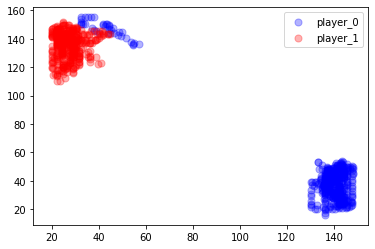

승자는 Player_1


In [0]:
plot_camera(train, 0)


게임번호 50입니다
Player0의 카메라 좌표 RMSE은 62.42271976379657입니다
Player1의 카메라 좌표 RMSE는 42.629128336452716입니다


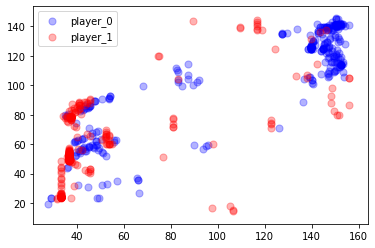

승자는 Player_1


In [0]:
plot_camera(train, 50)


게임번호 100입니다
Player0의 카메라 좌표 RMSE은 37.99665247311314입니다
Player1의 카메라 좌표 RMSE는 77.77091541944066입니다


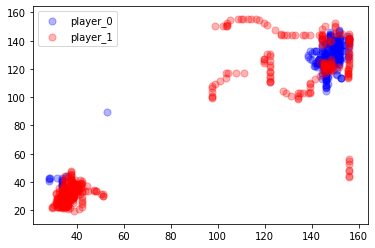

승자는 Player_1


In [0]:
plot_camera(train, 100)


게임번호 187입니다
Player0의 카메라 좌표 RMSE은 15.041478796536335입니다
player1의 Camera 플랏은 없습니다


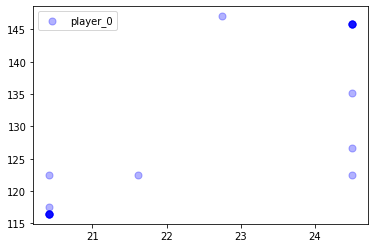

승자는 Player_0


In [0]:
plot_camera(train, 187)


게임번호 2000입니다
Player0의 카메라 좌표 RMSE은 11.550096755125626입니다
Player1의 카메라 좌표 RMSE는 51.61145550689172입니다


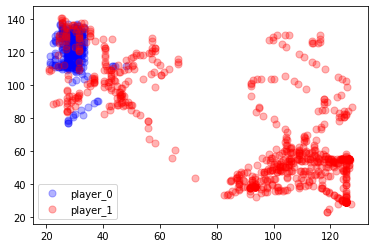

승자는 Player_1


In [0]:
plot_camera(train, 2000)


게임번호 10246입니다
player0의 Camera 플랏은 없습니다
Player1의 카메라 좌표 RMSE는 1.713450637146428입니다


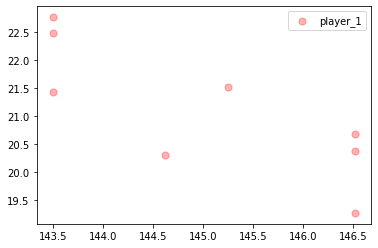

승자는 Player_1


In [0]:
plot_camera(train, 10246)


게임번호 12105입니다
Player0의 카메라 좌표 RMSE은 22.126735489877984입니다
player1의 Camera 플랏은 없습니다


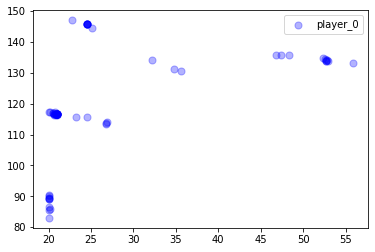

승자는 Player_0


In [0]:
plot_camera(train, 12105)


게임번호 13292입니다
Player0의 카메라 좌표 RMSE은 10.68257578745077입니다
player1의 Camera 플랏은 없습니다


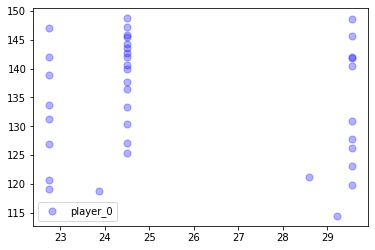

승자는 Player_0


In [0]:
plot_camera(train, 13292)


게임번호 17294입니다
Player0의 카메라 좌표 RMSE은 14.949982445676808입니다
player1의 Camera 플랏은 없습니다


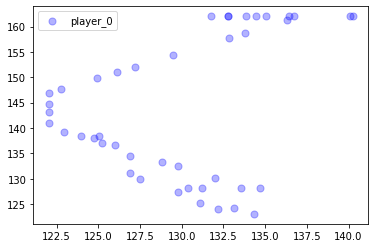

승자는 Player_1


In [0]:
plot_camera(train, 17294)


# 각 게임별 좌표들을 dictionary 형태로 train_x에 저장 (변수명 : Camera_list)

In [0]:


from tqdm import tqdm_notebook
def Add_cameraList(input = train):
  camera_list = []
  GID = train.game_id.unique().tolist()
  ## for문 안에
  for i in tqdm_notebook(GID):
    mydictionary = {}
    dataframe = input.loc[input['game_id']==i]
    dataframe = dataframe.loc[dataframe['event']=='Camera']
    dataframe_0 = dataframe.loc[dataframe['player']==0]
    dataframe_1 = dataframe.loc[dataframe['player']==1]
    if dataframe_0.shape[0]!=0:
      player0_camera = np.array([item.replace('at (', '').replace(')', '').split(',') for item in dataframe_0['event_contents']]).astype(float)
    else:
      player0_camera = np.nan

    if dataframe_1.shape[0]!=0:
      player1_camera = np.array([item.replace('at (', '').replace(')', '').split(',') for item in dataframe_1['event_contents']]).astype(float)
    else:
      player1_camera = np.nan

    mydictionary['player0'] = player0_camera
    mydictionary['player1'] = player1_camera

    camera_list.append(mydictionary)

  return camera_list

camera_list = Add_cameraList(train)

In [0]:
x_train = pd.read_pickle('x_train.pkl')
x_train['camera_list'] = camera_list
x_train.to_pickle('x_train.pkl')
x_train.head()

### Camera_list 일렬로 세움 player0와 player1 각각, 모든 각 게임들중 카메라 리스트가 가장 긴 리스트는 len이 몇일까?
* player 0: 3664, player 1: 4220

In [0]:

def location_length(camera_list = x_train.camera_list):
  result_list0 = []
  length_list0 = []
  result_list1 = []
  length_list1 = []

  for i in tqdm_notebook( range( len(camera_list)   ) ): # 
    
    player = 'player0'
    result_list0 = []
    if str(camera_list[i][player]) != 'nan':
      for j in range( len( camera_list[i][player].tolist() )  ):
        
          location_j = camera_list[i][player].tolist()[j]
          result_list0 += location_j                  ## i번째 게임에서 p0의 좌표들 result_list0에 모두 저장됨
    else:
      print(f'{i}번째 경기에서 player0의 카메라 없음')
    length_list0.append( len(result_list0)  )         ## i번째 게임에서 p0의 좌표 개수가 몇인지 append

    player = 'player1'
    result_list1 = []
    if str(camera_list[i][player]) != 'nan':
      for j in range( len( camera_list[i][player].tolist() )  ):
        
          location_j = camera_list[i][player].tolist()[j]
          result_list1 += location_j                   ## i번째 게임에서 p1의 좌표들 result_list1에 모두 저장됨 
    else:
      print(f'{i}번째 경기에서 player1의 카메라 없음')
    length_list1.append( len(result_list1)  )          ## i번째 게임에서 p1의 좌표 개수가 몇인지 append
  return length_list0, length_list1

length_list0, length_list1 = location_length()


187번째 경기에서 player1의 카메라 없음
10246번째 경기에서 player0의 카메라 없음
12105번째 경기에서 player1의 카메라 없음
13292번째 경기에서 player1의 카메라 없음
14675번째 경기에서 player1의 카메라 없음
17294번째 경기에서 player1의 카메라 없음
21149번째 경기에서 player0의 카메라 없음
23337번째 경기에서 player0의 카메라 없음
24423번째 경기에서 player1의 카메라 없음
24855번째 경기에서 player1의 카메라 없음
24858번째 경기에서 player1의 카메라 없음
25891번째 경기에서 player0의 카메라 없음
26243번째 경기에서 player1의 카메라 없음
26339번째 경기에서 player1의 카메라 없음
27249번째 경기에서 player1의 카메라 없음
27818번째 경기에서 player0의 카메라 없음
32254번째 경기에서 player1의 카메라 없음
33101번째 경기에서 player1의 카메라 없음
34423번째 경기에서 player1의 카메라 없음
34843번째 경기에서 player1의 카메라 없음
35288번째 경기에서 player0의 카메라 없음
37967번째 경기에서 player1의 카메라 없음


In [0]:
print(np.max(length_list0))
print(np.max(length_list1))


3664
4020


# 각 게임당 player0 와 player1의 카메라 리스트를 일렬로 병합해서 (빈 곳은 0으로 채움) array형태로 저장

In [0]:
x_train = pd.read_pickle('x_train.pkl')
camera_list = x_train.camera_list

In [0]:

## result_list0 : i번째 게임에서 플레이어0의 모든 카메라 좌표들을 일렬로 세운거
player = 'player0'
i = 10246
result_list0 = []
if str(camera_list[i][player]) != 'nan':
  for j in range( len( camera_list[i][player].tolist() )  ):
    location_j = camera_list[i][player].tolist()[j]
    result_list0 += location_j
else:
  print(f'{i}번째 경기에서 player0의 카메라 없음')
  
result_list0 = result_list0 + np.zeros(3664 - len(result_list0)).tolist()

## result_list1 : i번째 게임에서 플레이어1의 모든 카메라 좌표들을 일렬로 세운거
player = 'player1'
result_list1 = []
if str(camera_list[i][player]) != 'nan':
  for j in range( len( camera_list[i][player].tolist() )  ):
    location_j = camera_list[i][player].tolist()[j]
    result_list1 += location_j
else:
  print(f'{i}번째 경기에서 player0의 카메라 없음')
result_list1 = result_list1 + np.zeros(4220 - len(result_list1)).tolist()

####### result_list0와 result_list1 모두 일렬로 합쳐버리기 => 게임 i번째에서의 카메라 리스트가 일렬이 됨.
result_list = result_list0 + result_list1
result_array = np.zeros(  len(camera_list)* (3664+4220) )
result_array = result_array.reshape(  len(camera_list), 3664+4220)

10246번째 경기에서 player0의 카메라 없음


In [0]:

def for_reduction_camera_array(camera_list = camera_list):
  ### 빈 array 미리 생성
  max_0 = 3664
  max_1 = 4220
  result_array = np.zeros(  len(camera_list)* (max_0+max_1) ).reshape(  len(camera_list), (max_0+max_1)  )

  from tqdm import tqdm_notebook
  for i in tqdm_notebook(range( len(camera_list) ) ): # 
    player = 'player0'
    result_list0 = []
    if str(camera_list[i][player]) != 'nan':

      for j in range( len( camera_list[i][player].tolist() )  ):
          location_j = camera_list[i][player].tolist()[j]
          result_list0 += location_j
          ## result_list0 : i번째 게임에서 플레이어0의 모든 카메라 좌표들을 일렬로 세운거
    else:
      print(f'{i}번째 경기에서 player0의 카메라 없음')
    result_list0 = result_list0 + np.zeros(max_0 - len(result_list0)).tolist()


    player = 'player1'
    result_list1 = []
    if str(camera_list[i][player]) != 'nan':
      for j in range( len( camera_list[i][player].tolist() )  ):
          location_j = camera_list[i][player].tolist()[j]
          result_list1 += location_j
          ## result_list1 : i번째 게임에서 플레이어1의 모든 카메라 좌표들을 일렬로 세운거
    else:
      print(f'{i}번째 경기에서 player1의 카메라 없음')
    result_list1 = result_list1 + np.zeros(max_1 - len(result_list1)).tolist()

    ####### result_list0와 result_list1 모두 일렬로 합쳐버리기 => 게임 i번째에서의 카메라 리스트가 일렬이 됨.
    result_list = result_list0 + result_list1
    ### result_list를 ID 순서를 고려하여 result_array의 해당 row에 저장
    result_array[i,:] = result_list
  return result_array

camera_array = for_reduction_camera_array(camera_list = camera_list)

187번째 경기에서 player1의 카메라 없음
10246번째 경기에서 player0의 카메라 없음
12105번째 경기에서 player1의 카메라 없음
13292번째 경기에서 player1의 카메라 없음
14675번째 경기에서 player1의 카메라 없음
17294번째 경기에서 player1의 카메라 없음
21149번째 경기에서 player0의 카메라 없음
23337번째 경기에서 player0의 카메라 없음
24423번째 경기에서 player1의 카메라 없음
24855번째 경기에서 player1의 카메라 없음
24858번째 경기에서 player1의 카메라 없음
25891번째 경기에서 player0의 카메라 없음
26243번째 경기에서 player1의 카메라 없음
26339번째 경기에서 player1의 카메라 없음
27249번째 경기에서 player1의 카메라 없음
27818번째 경기에서 player0의 카메라 없음
32254번째 경기에서 player1의 카메라 없음
33101번째 경기에서 player1의 카메라 없음
34423번째 경기에서 player1의 카메라 없음
34843번째 경기에서 player1의 카메라 없음
35288번째 경기에서 player0의 카메라 없음
37967번째 경기에서 player1의 카메라 없음



In [0]:
pd.DataFrame(camera_array).to_pickle('camera_array.pkl')